# PS3 Solutions

## Supporting packages

In [55]:
import sys
sys.path.append('src/')
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import attitude as att # For basic inertia calculations

## Useful constants

In [56]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

# 1. Rotational Stability

## Decompose spacecraft
Let's set up the parameters for the main components of the CubeSat (chassis and four panels). To simplify the problem we assume here that all four panels are identical and are hinged at the edges of the chassis. In specifying dimensions and masses, we will be using SI units throughtout this notebook.

In [57]:
m_chassis = 1.6  # [kg]
m_panel   = 0.1  # [kg]
L         = 0.22 # [m] Long-axis dimension for both chassis and panel
W         = 0.08 # [m] Short-axis dimensions for both chassis and panel

total_mass = m_chassis + 4*m_panel

Ok, clearly, panels have smaller moments of inertia. However, remember that the panels will be placed far of the COM. So, we'll need to use the parallel axis theorem to compute the total inertial tensor.

#### Now we need to define the panel angles and use these to specify the positions of the panels relative to the chassis to find the overall center of mass.

#### Below we show two sets of deployment angles. The first case corresponds to the "packaged" configuration. That is the configuration the spacecraft is in right after it's deployed.

In [58]:
# Packaged configuration
theta_t = 0 # Angle from folded state for top panel (0 to pi)
theta_b = 0 # Angle from folded state for bottom panel (0 to pi)
theta_l = 0 # Angle from folded state for left panel (0 to pi/2)
theta_r = 0 # Angle from folded state for right panel (0 to pi/2)

#### The second configuration is the fully deployed one. All the panels are deployed to the full extent. This is the configuration that corresponds to the maximum available solar power.

In [59]:
# Fully deployed configuration

# left and right panels
theta_l = 90 * deg2rad # Angle from folded state for left panel (0 to pi/2)
theta_r = 90 * deg2rad # Angle from folded state for right panel (0 to pi/2)

# top and bottom panels
theta_t = 180 * deg2rad # Angle from folded state for top panel (0 to pi)
theta_b = 180 * deg2rad # Angle from folded state for bottom panel (0 to pi)

## Determine centroid location

#### Next thing we do we specify the offsets of the COM for each solar panel with respect to the COM of the chassis.

In [60]:
# top panel
dx_t = - L / 2 + L / 2 * np.cos(theta_t)
dy_t = 0.0
dz_t = - W / 2 - L / 2 * np.sin(theta_t)

# bottom panel
dx_b = - L / 2 + L / 2 * np.cos(theta_b)
dy_b =   0.0
dz_b = + W / 2 + L / 2 * np.sin(theta_b)

# left panel
dx_l =   0.0
dy_l = - W / 2 - W / 2 * np.sin(theta_l)
dz_l = - W / 2 + W / 2 * np.cos(theta_l)

# right panel
dx_r =   0.0
dy_r = + W / 2 + W / 2 * np.sin(theta_r)
dz_r = - W / 2 + W / 2 * np.cos(theta_r)


Let's create arrays with those offsets

In [61]:
# Offset positions of the panel centroids
dr_t = np.array([dx_t, dy_t, dz_t])
dr_b = np.array([dx_b, dy_b, dz_b])
dr_l = np.array([dx_l, dy_l, dz_l])
dr_r = np.array([dx_r, dy_r, dz_r])

## Calculate center of mass

#### First, we compute the total mass

In [62]:
m_total = m_chassis + 4 * m_panel
print(m_total)

2.0


#### Next, we compute the COM of the spacecraft (for the fully deployed configuration). The center of mass of the spacecraft is a weighted average of the centers of mass of its components.

In [63]:
COM     = m_panel * (dr_t + dr_b + dr_l + dr_r) / m_total
print(COM)

[-0.022  0.    -0.004]


### Wait! But why is there nothing related to the chassis in the COM equation above?

## Calculate each shape's moments of inertia

In [64]:
I_chassis = att.inertia_box(m_chassis, L, W, W) # axes: x-forward, y-right, z-down
I_panel   = att.inertia_plate(m_panel, L, W)

Let's look at the inertia tensors for the chassis. We multiply by 1000 just to make numbers closer to unity

In [65]:
print(I_chassis * 1000)

[[1.70666667 0.         0.        ]
 [0.         7.30666667 0.        ]
 [0.         0.         7.30666667]]


Let's look at the inertia tensor for a panel

In [66]:
print(I_panel   * 1000)

[[0.05333333 0.         0.        ]
 [0.         0.40333333 0.        ]
 [0.         0.         0.45666667]]


#### Now that we know the individual inertia tensors COMs, we can take each component and rotate & translate their moments of inertia to find the overall CubeSat's inertia tensor.

Here we have to be careful of our sign convention for the deployment angle of each panel, since a positive angle from the stowed configuration may be in a negative axis direction.  The left and right panels also start in a vertical orientation so their rotations are offset by $\pm \pi/2$

In [67]:
# First we take care of the chassis. The variable named "offset" is the offset between the COM of the component and the COM of the spacecraft.

offset_chassis = COM
I_chassis_COM  = att.inertia_translate(m_chassis, I_chassis, offset_chassis[0], offset_chassis[1], offset_chassis[2])

# For each panel, rotate first about its centroid and then translate through parallel axis theorem
I_panel_t_rot = att.inertia_rotate(I_panel, theta_t, 2)
offset_t      = COM - dr_t
I_panel_t_COM = att.inertia_translate(m_panel, I_panel_t_rot, offset_t[0], offset_t[1], offset_t[2])

I_panel_b_rot = att.inertia_rotate(I_panel, - theta_b, 2)
offset_b      = COM - dr_b
I_panel_b_COM = att.inertia_translate(m_panel, I_panel_b_rot, offset_b[0],offset_b[1], offset_b[2])

I_panel_l_rot = att.inertia_rotate(I_panel, - pi/2 + theta_l, 1)
offset_l      = COM - dr_l
I_panel_l_COM = att.inertia_translate(m_panel, I_panel_l_rot, offset_l[0], offset_l[1], offset_l[2])

I_panel_r_rot = att.inertia_rotate(I_panel, + pi/2 - theta_r, 1)
offset_r      = COM - dr_r
I_panel_r_COM = att.inertia_translate(m_panel, I_panel_r_rot, offset_r[0], offset_r[1], offset_r[2])

## 1a. Add up individual inertias

In [68]:
# Sum all the inertias in the Center of Mass coordinate frame
I_cubesat = I_chassis_COM + I_panel_t_COM + I_panel_b_COM + I_panel_l_COM + I_panel_r_COM
print(I_cubesat)

[[0.003808   0.         0.000176  ]
 [0.         0.01824    0.        ]
 [0.000176   0.         0.01912533]]


As you can see, it is not a diagonal matrix. So, the coordinate axes are not principal axes.

### Find principal axes

In [69]:
principal_moments, principal_axes = att.principal_inertia(I_cubesat)

## 1b. Let's take a look at the principal moments of inertia

In [70]:
print(principal_moments)

[0.00380598 0.01912736 0.01824   ]


## 1c. Let's take a look at the principal axes

In [71]:
print(principal_axes)

[[-0.99993401 -0.01148798  0.        ]
 [ 0.          0.          1.        ]
 [ 0.01148798 -0.99993401  0.        ]]


These do not align with the spacecraft coordinate axes, which align exactly with the x-axis, y-axis, and z-axis

## 1d. Given this principal moments and axes, does this look like we will be rotating stably around the spacecraft y-axis?

No, when fully deployed, the y-axis is the intermediate axis. This means that rotation about the y-axis will be unstable.

# 1e. Let's put this all together and make one big function that can be used to study rotational stability

In [72]:
def Iyz_diff(theta_top,theta_side):

    ## put here blocks of code from block 2 to block 6.
    theta_t = theta_top
    theta_b = theta_top

    theta_l = theta_side
    theta_r = theta_side

    # top panel
    dx_t = - L / 2 + L / 2 * np.cos(theta_t)
    dy_t = 0.0
    dz_t = + W / 2 + L / 2 * np.sin(theta_t)

    # bottom panel
    dx_b = - L / 2 + L / 2 * np.cos(theta_b)
    dy_b =   0.0
    dz_b = - W / 2 - L / 2 * np.sin(theta_b)

    # left panel
    dx_l =   0.0
    dy_l = - W / 2 - W / 2 * np.sin(theta_l)
    dz_l = + W / 2 - W / 2 * np.cos(theta_l)

    # right panel
    dx_r =   0.0
    dy_r = + W / 2 + W / 2 * np.sin(theta_r)
    dz_r = + W / 2 - W / 2 * np.cos(theta_r)

    # Offset positions of the panel centroids
    dr_t = np.array([dx_t, dy_t, dz_t])
    dr_b = np.array([dx_b, dy_b, dz_b])
    dr_l = np.array([dx_l, dy_l, dz_l])
    dr_r = np.array([dx_r, dy_r, dz_r])

    # total mass
    m_total = m_chassis + 4 * m_panel

    # center of mass
    COM     = m_panel * (dr_t + dr_b + dr_l + dr_r) / m_total

    # inertia tensors for chassis and panels
    I_chassis = att.inertia_box(m_chassis, L, W, W) # axes: x-forward, y-right, z-down
    I_panel   = att.inertia_plate(m_panel, L, W)

    # First we take care of the chassis. The variable named "offset" is the offset between the COM of the component and the COM of the spacecraft.
    offset_chassis = COM
    I_chassis_COM  = att.inertia_translate(m_chassis, I_chassis, offset_chassis[0], offset_chassis[1], offset_chassis[2])

    # For each panel, rotate first about its centroid and then translate through parallel axis theorem
    I_panel_t_rot = att.inertia_rotate(I_panel, theta_t, 2)
    offset_t      = COM - dr_t
    I_panel_t_COM = att.inertia_translate(m_panel, I_panel_t_rot, offset_t[0], offset_t[1], offset_t[2])

    I_panel_b_rot = att.inertia_rotate(I_panel, - theta_b, 2)
    offset_b      = COM - dr_b
    I_panel_b_COM = att.inertia_translate(m_panel, I_panel_b_rot, offset_b[0],offset_b[1], offset_b[2])

    I_panel_l_rot = att.inertia_rotate(I_panel, - pi/2 + theta_l, 1)
    offset_l      = COM - dr_l
    I_panel_l_COM = att.inertia_translate(m_panel, I_panel_l_rot, offset_l[0], offset_l[1], offset_l[2])

    I_panel_r_rot = att.inertia_rotate(I_panel, + pi/2 - theta_r, 1)
    offset_r      = COM - dr_r
    I_panel_r_COM = att.inertia_translate(m_panel, I_panel_r_rot, offset_r[0], offset_r[1], offset_r[2])

    # Sum all the inertias in the Center of Mass coordinate frame
    I_cubesat = I_chassis_COM + I_panel_t_COM + I_panel_b_COM + I_panel_l_COM + I_panel_r_COM

    # compute principal moments of inertia and inertia axes
    principal_moments, principal_axes = att.principal_inertia(I_cubesat)

    return principal_moments[2] - principal_moments[1]

## Let's use this function

In [73]:
# create a grid of values for the deployments angles
theta_top  = np.linspace(0.1, 180, 250) * deg2rad
theta_side = np.linspace(0.1, 90, 250) * deg2rad
theta_top, theta_side = np.meshgrid(theta_top, theta_side)

# initialize a grid of values
dI = np.zeros(theta_top.shape)

# call function
for i in range(dI.shape[0]):
    for j in range(dI.shape[1]):
        dI[i,j] = Iyz_diff(theta_top[i,j],theta_side[i,j])

## Plot results

Text(0, 0.5, '$\\theta_{side}$, [deg]')

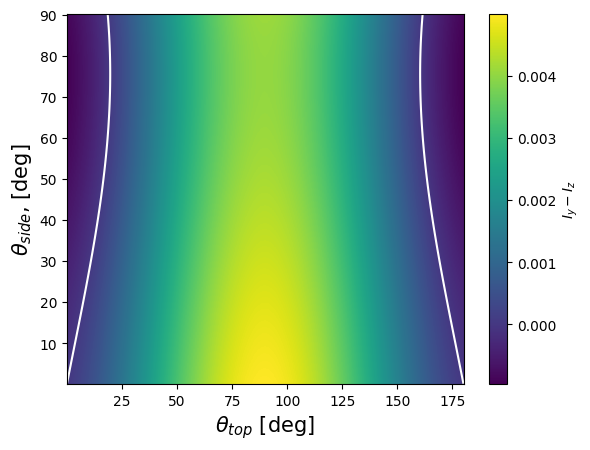

In [74]:
plt.figure()
plt.pcolor(theta_top * rad2deg, theta_side * rad2deg, dI)
cbar = plt.colorbar()
cbar.set_label(r'$I_{y} - I_{z}$')
plt.contour(theta_top * rad2deg, theta_side * rad2deg, dI, levels=np.array([0.0]),colors='w')
plt.xlabel(r'$\theta_{top}$ [deg]',fontsize=15)
plt.ylabel(r'$\theta_{side}$, [deg]',fontsize=15)

## 1f. Solar panels with largest effect

From the graph above, you can see that variations in the top/bottom panels result in larger variations in the difference between Iy and Iz.

## 1g. Range of $\theta_t$ for y-axis stability

From the plot above, the range of $\theta_t$ where we have stable rotation about the y-axis is approximately 18 degrees to 162 degrees.

# 2. Solar Power

## 2a. Effect of deployment angle

The maximum power received occurs when $\theta_t$ is 180 degrees and $\theta_r = \theta_l = $ 90 degrees. Decreasing the top angle from 180 will decrease its effective area and thus the available power. If it is decreased beyond 90 degrees, it will also cause part of the top of the chasis to be in shadow. Similarly, decreasing the left and right angles from 90 degrees will result in a smaller effective area and available power.

## 2b. Available power at full deployment

Surface Area of each component

In [75]:
A_bus            = L*W
A_bus_front      = W*W
A_top_panel      = L*W
A_side_panel     = L*W
W_per_sq_meter   = 1370 # watts per square meter
panel_efficiency = 0.3
print(A_bus)

0.0176


#### Define functions that compute projected areas

In [76]:
projected_area_top_obstruction = lambda theta_top: -A_top_panel*np.cos(theta_top)
projected_area_top_no_obstruction = lambda theta_top: 0 if theta_top < pi/2 else -A_top_panel*np.cos(theta_top)
projected_area = lambda theta_top, theta_side: A_bus + projected_area_top_obstruction(theta_top) + 2*A_side_panel*np.sin(theta_side)
power = lambda theta_top, theta_side: W_per_sq_meter * panel_efficiency * projected_area(theta_top, theta_side)


#### Compute power over a grid of deployment angles

In [77]:
# initialize a grid of values
power_w = np.zeros(theta_top.shape)

# call function
for i in range(power_w.shape[0]):
    for j in range(power_w.shape[1]):
        power_w[i,j] = power(theta_top[i,j],theta_side[i,j])

#### Print results 

In [78]:
required_power = power(pi/2, pi/2)
deployed_power = power(pi, pi/2)
print("The required power is: ", required_power)
print("The power when fully deployed is: ",deployed_power)

The required power is:  21.7008
The power when fully deployed is:  28.9344


#### Yes, there is sufficient power when fully deployed.

## 2c. Plot power curve

In [79]:
frontal_area = lambda theta_top : A_bus_front + 2 * A_top_panel * np.sin(theta_top)
area_front = np.zeros(theta_top.shape)

# call function
for i in range(power_w.shape[0]):
    for j in range(power_w.shape[1]):
        area_front[i,j] = frontal_area(theta_top[i,j])

### The plot below includes a red curve above which the spacecraft has sufficient available power.

<a list of 50 text.Text objects>

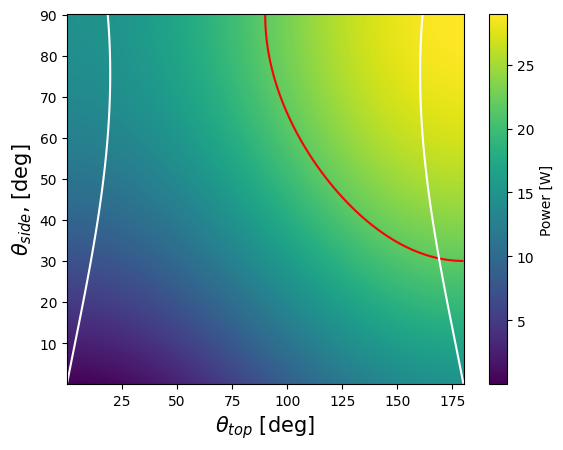

In [80]:
plt.figure()
plt.pcolor(theta_top * rad2deg, theta_side * rad2deg, power_w)
cbar = plt.colorbar()
cbar.set_label(r'Power [W]')
plt.contour(theta_top * rad2deg, theta_side * rad2deg, power_w, levels=np.array([required_power]),colors='r')
plt.contour(theta_top * rad2deg, theta_side * rad2deg, dI, levels=np.array([0.0]),colors='w')
# contour_frontal = plt.contour(theta_top * rad2deg, theta_side * rad2deg, 2/area_front, levels=total_mass/np.linspace(frontal_area(pi/2),A_bus_front,12),colors='k')
plt.xlabel(r'$\theta_{top}$ [deg]',fontsize=15)
plt.ylabel(r'$\theta_{side}$, [deg]',fontsize=15)
plt.clabel(contour_frontal, inline=True, fmt='%1.0f', fontsize=10)

# 3. Atmospheric Drag

## 3a. Spacecraft lifetime when fully deployed.

When fully deployed, the mass to frontal area ratio is:

m = 2 [kg]

A = 8 [cm] * 8 [cm]

m/A = 312.5 [kg/m^2]

From the given plot, this corresponds to a lifetime of about 1300 days.

## 3b. Maximum drag

Maximum drag will occur at the maximum frontal area, which occurs when the top and bottom panels are at 90 degrees. With this configuration,

m = 2 [kg]

A = 8 [cm] * 8 [cm] + 2 * 8 [cm] * 22 [cm]

m/A = 48.1 [kg/m^2]

From the given plot, this corresponds to a lifetime of about 200 days.

## 3c. Configuration satisfying all requirements

The plot above also shows the m/A values as black contour lines. From the plot provided in the pset, an m/A value of about 90 is needed. Thus, a configuration that satisfies the three requirements will be to the right of the "m/A = 89" contour line, above the red power curve, and between the white inertia curves. This region where all constraints are satisfied is within the blue contour in the plot below. 

<a list of 20 text.Text objects>

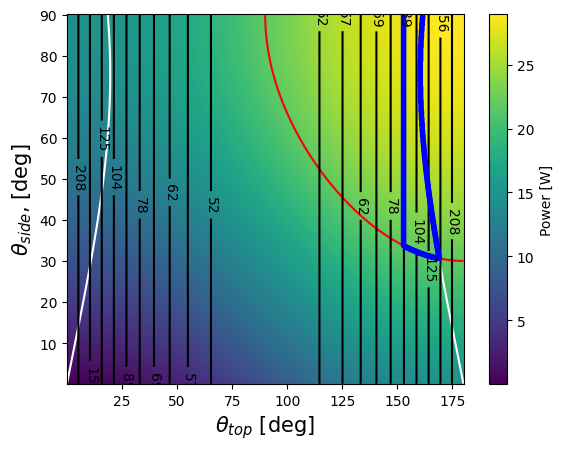

In [81]:
plt.figure()
plt.pcolor(theta_top * rad2deg, theta_side * rad2deg, power_w)
cbar = plt.colorbar()
cbar.set_label(r'Power [W]')
plt.contour(theta_top * rad2deg, theta_side * rad2deg, power_w, levels=np.array([required_power]),colors='r')
plt.contour(theta_top * rad2deg, theta_side * rad2deg, dI, levels=np.array([0.0]),colors='w')
contour_frontal = plt.contour(theta_top * rad2deg, theta_side * rad2deg, total_mass/area_front, levels=total_mass/np.linspace(frontal_area(pi/2),A_bus_front,12),colors='k')
all_constraints = (dI > 0) * (power_w > 21.7) * (total_mass/area_front > 89)
plt.contour(theta_top * rad2deg, theta_side * rad2deg, all_constraints, levels=np.array([0.000001]),colors='b',linewidths=4)
plt.xlabel(r'$\theta_{top}$ [deg]',fontsize=15)
plt.ylabel(r'$\theta_{side}$, [deg]',fontsize=15)
plt.clabel(contour_frontal, inline=True, fmt='%1.0f', fontsize=10)